In [11]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Import only basic torch components to avoid version conflicts
try:
    import torch
    import torch.nn as nn
    # Avoid importing torch.optim to bypass the error
    print("PyTorch imported successfully")
except ImportError as e:
    print(f"PyTorch import error: {e}")
    print("Please try: pip install torch==2.1.0 --force-reinstall")

PyTorch imported successfully


In [2]:
np.random.seed(42)
torch.manual_seed(42)

print("Matrix Factorization Baseline for GNN Music Recommender")
print("=" * 60)

Matrix Factorization Baseline for GNN Music Recommender


# 1. Data Loading and Preprocessing

In [15]:
def load_spotify_data(file_path):
    """Load and preprocess Spotify dataset"""
    print("Loading Spotify dataset...")

    with open(file_path, 'r') as f:
        data = json.load(f)

    interactions = []

    for playlist in data['playlists']:
        playlist_id = playlist['pid']
        for track in playlist['tracks']:
            interactions.append({
                'playlist_id': playlist_id,
                'track_uri': track['track_uri'],
                'track_name': track['track_name'],
                'artist_name': track['artist_name'],
            })

    df = pd.DataFrame(interactions)
    print(f"Loaded {len(df)} interactions")
    return df

# Load your data
data_path = "../data/processed/spotify_hybrid_sampled_50000.json"
df = load_spotify_data(data_path)


Loading Spotify dataset...
Loaded 2217713 interactions


# 2. Create User-item Interaction Matrix

In [25]:
def create_interaction_matrix_simple(df, min_interactions=3):
    """Create interaction matrix - simplified version"""

    # Filter
    playlist_counts = df['playlist_id'].value_counts()
    track_counts = df['track_uri'].value_counts()

    valid_playlists = playlist_counts[playlist_counts >= min_interactions].index
    valid_tracks = track_counts[track_counts >= min_interactions].index

    df_filtered = df[
        (df['playlist_id'].isin(valid_playlists)) &
        (df['track_uri'].isin(valid_tracks))
    ].copy()

    print(f"After filtering: {df_filtered['playlist_id'].nunique()} playlists, {df_filtered['track_uri'].nunique()} tracks")

    # Create mappings
    playlist_encoder = LabelEncoder()
    track_encoder = LabelEncoder()

    df_filtered['playlist_idx'] = playlist_encoder.fit_transform(df_filtered['playlist_id'])
    df_filtered['track_idx'] = track_encoder.fit_transform(df_filtered['track_uri'])

    return df_filtered, playlist_encoder, track_encoder

df_processed, playlist_encoder, track_encoder = create_interaction_matrix_simple(df)

# Get dimensions
n_users = df_processed['playlist_idx'].nunique()
n_items = df_processed['track_idx'].nunique()
print(f"Matrix dimensions: {n_users} x {n_items}")

After filtering: 49863 playlists, 95365 tracks
Matrix dimensions: 49863 x 95365


# 3. Matrix Factorization Model

In [26]:
class SimpleMatrixFactorization:
    def __init__(self, n_users, n_items, n_factors=50, learning_rate=0.01, reg=0.01):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.reg = reg

        # Initialize embeddings
        np.random.seed(42)
        self.user_factors = np.random.normal(0, 0.1, (n_users, n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, n_factors))
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = 0.0

    def predict(self, user_id, item_id):
        """Predict rating for user-item pair"""
        prediction = (self.global_bias +
                     self.user_bias[user_id] +
                     self.item_bias[item_id] +
                     np.dot(self.user_factors[user_id], self.item_factors[item_id]))
        return 1.0 / (1.0 + np.exp(-prediction))  # Sigmoid

    def train_step(self, user_id, item_id, rating):
        """Single training step"""
        # Get prediction
        pred = self.predict(user_id, item_id)
        error = rating - pred

        # Gradients
        user_factor = self.user_factors[user_id].copy()
        item_factor = self.item_factors[item_id].copy()

        # Update factors
        self.user_factors[user_id] += self.learning_rate * (error * item_factor - self.reg * user_factor)
        self.item_factors[item_id] += self.learning_rate * (error * user_factor - self.reg * item_factor)

        # Update biases
        self.user_bias[user_id] += self.learning_rate * (error - self.reg * self.user_bias[user_id])
        self.item_bias[item_id] += self.learning_rate * (error - self.reg * self.item_bias[item_id])

        return error ** 2

    def fit(self, interactions_df, epochs=20, verbose=True):
        """Train the model"""

        # Prepare training data
        positive_pairs = interactions_df[['playlist_idx', 'track_idx']].values
        positive_set = set(map(tuple, positive_pairs))

        # Generate negative samples
        print("Generating negative samples...")
        negative_pairs = []
        target_negatives = len(positive_pairs)

        while len(negative_pairs) < target_negatives:
            user = np.random.randint(0, self.n_users)
            item = np.random.randint(0, self.n_items)

            if (user, item) not in positive_set:
                negative_pairs.append([user, item])

        # Combine training data
        all_pairs = np.vstack([positive_pairs, negative_pairs])
        all_labels = np.hstack([np.ones(len(positive_pairs)), np.zeros(len(negative_pairs))])

        # Shuffle
        indices = np.random.permutation(len(all_pairs))
        all_pairs = all_pairs[indices]
        all_labels = all_labels[indices]

        print(f"Training on {len(all_pairs)} samples...")

        # Training loop
        losses = []

        for epoch in range(epochs):
            epoch_loss = 0

            for i, (user_id, item_id) in enumerate(all_pairs):
                rating = all_labels[i]
                loss = self.train_step(user_id, item_id, rating)
                epoch_loss += loss

                if i % 10000 == 0 and verbose:
                    print(f"Epoch {epoch+1}, Sample {i}, Loss: {loss:.4f}")

            avg_loss = epoch_loss / len(all_pairs)
            losses.append(avg_loss)

            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

        return losses

    def predict_all_for_user(self, user_id):
        """Predict ratings for all items for a user"""
        predictions = []
        for item_id in range(self.n_items):
            pred = self.predict(user_id, item_id)
            predictions.append(pred)
        return np.array(predictions)

# 4. Train-test Split

In [27]:
def simple_train_test_split(df_processed, test_ratio=0.2):
    """Simple train-test split"""

    # Group by user
    train_data = []
    test_data = []

    for user_id in df_processed['playlist_idx'].unique():
        user_tracks = df_processed[df_processed['playlist_idx'] == user_id]['track_idx'].values

        if len(user_tracks) > 1:
            n_test = max(1, int(len(user_tracks) * test_ratio))
            test_tracks = np.random.choice(user_tracks, n_test, replace=False)
            train_tracks = [t for t in user_tracks if t not in test_tracks]

            # Add to train
            for track in train_tracks:
                train_data.append({'playlist_idx': user_id, 'track_idx': track})

            # Add to test
            for track in test_tracks:
                test_data.append({'playlist_idx': user_id, 'track_idx': track})
        else:
            # All to train if only 1 interaction
            for track in user_tracks:
                train_data.append({'playlist_idx': user_id, 'track_idx': track})

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    print(f"Train: {len(train_df)} interactions")
    print(f"Test: {len(test_df)} interactions")

    return train_df, test_df

# Create train-test split
train_df, test_df = simple_train_test_split(df_processed)

Train: 1539283 interactions
Test: 361646 interactions


# 5. Training


Training Matrix Factorization model...
Generating negative samples...
Training on 3078566 samples...
Epoch 1, Sample 0, Loss: 0.2783
Epoch 1, Sample 10000, Loss: 0.2486
Epoch 1, Sample 20000, Loss: 0.2648
Epoch 1, Sample 30000, Loss: 0.2334
Epoch 1, Sample 40000, Loss: 0.2474
Epoch 1, Sample 50000, Loss: 0.2107
Epoch 1, Sample 60000, Loss: 0.2554
Epoch 1, Sample 70000, Loss: 0.2545
Epoch 1, Sample 80000, Loss: 0.2576
Epoch 1, Sample 90000, Loss: 0.2458
Epoch 1, Sample 100000, Loss: 0.2475
Epoch 1, Sample 110000, Loss: 0.2235
Epoch 1, Sample 120000, Loss: 0.2372
Epoch 1, Sample 130000, Loss: 0.2429
Epoch 1, Sample 140000, Loss: 0.2576
Epoch 1, Sample 150000, Loss: 0.2496
Epoch 1, Sample 160000, Loss: 0.2297
Epoch 1, Sample 170000, Loss: 0.2682
Epoch 1, Sample 180000, Loss: 0.2540
Epoch 1, Sample 190000, Loss: 0.2549
Epoch 1, Sample 200000, Loss: 0.2272
Epoch 1, Sample 210000, Loss: 0.2664
Epoch 1, Sample 220000, Loss: 0.2522
Epoch 1, Sample 230000, Loss: 0.2506
Epoch 1, Sample 240000, 

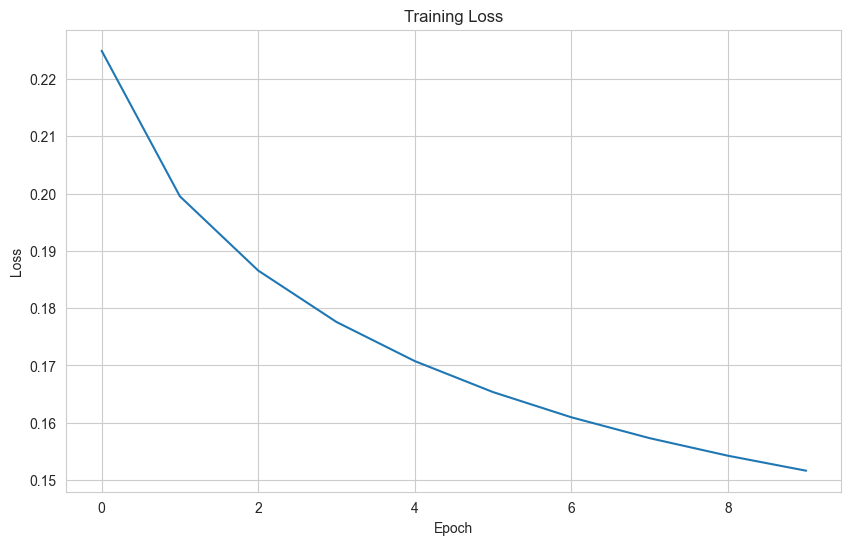

In [28]:
print("\nTraining Matrix Factorization model...")
model = SimpleMatrixFactorization(
    n_users=n_users,
    n_items=n_items,
    n_factors=32,  # Smaller for speed
    learning_rate=0.01,
    reg=0.01
)

# Train
losses = model.fit(train_df, epochs=10, verbose=True)

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 6. Evaluation

In [29]:
def evaluate_fast(model, test_df, train_df, k=10, max_users=100):
    """FAST evaluation - much faster than the original"""

    print(f"Fast evaluation with max {max_users} users...")

    precisions = []
    recalls = []

    test_grouped = test_df.groupby('playlist_idx')['track_idx'].apply(list).to_dict()
    train_grouped = train_df.groupby('playlist_idx')['track_idx'].apply(set).to_dict()

    # Sample users if too many (for speed)
    users_to_evaluate = list(test_grouped.keys())
    if len(users_to_evaluate) > max_users:
        users_to_evaluate = np.random.choice(users_to_evaluate, max_users, replace=False)
        print(f"Sampling {max_users} users out of {len(test_grouped)} for speed")

    for i, user_id in enumerate(users_to_evaluate):
        if i % 20 == 0:
            print(f"Evaluating user {i+1}/{len(users_to_evaluate)}")

        true_items = test_grouped[user_id]
        if len(true_items) == 0:
            continue

        # Get user's training items (for filtering)
        user_train_items = train_grouped.get(user_id, set())

        # FAST: Only compute predictions for candidate items (not all items)
        # Get candidate items: random sample + some popular items
        candidate_items = set()

        # Add random items
        random_items = np.random.choice(model.n_items, min(500, model.n_items), replace=False)
        candidate_items.update(random_items)

        # Add true test items (to ensure recall can be > 0)
        candidate_items.update(true_items)

        # Remove training items
        candidate_items = candidate_items - user_train_items
        candidate_items = list(candidate_items)

        # Compute predictions only for candidates
        item_scores = []
        for item_id in candidate_items:
            score = model.predict(user_id, item_id)
            item_scores.append((item_id, score))

        # Sort and get top-k
        item_scores.sort(key=lambda x: x[1], reverse=True)
        top_k_items = [item for item, score in item_scores[:k]]

        # Calculate metrics
        relevant_items = set(true_items)
        recommended_items = set(top_k_items)

        if len(recommended_items) > 0:
            precision = len(relevant_items & recommended_items) / len(recommended_items)
            precisions.append(precision)

        if len(relevant_items) > 0:
            recall = len(relevant_items & recommended_items) / len(relevant_items)
            recalls.append(recall)

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0

    print(f"Evaluated {len(precisions)} users")
    return avg_precision, avg_recall

# Evaluate (MUCH FASTER)
print("\nEvaluating model...")

# Try the fast evaluation first
precision_5, recall_5 = evaluate_fast(model, test_df, train_df, k=5, max_users=50)
precision_10, recall_10 = evaluate_fast(model, test_df, train_df, k=10, max_users=50)

print(f"\nFast Evaluation Results:")
print(f"Precision@5: {precision_5:.4f}")
print(f"Recall@5: {recall_5:.4f}")
print(f"Precision@10: {precision_10:.4f}")
print(f"Recall@10: {recall_10:.4f}")


Evaluating model...
Fast evaluation with max 50 users...
Sampling 50 users out of 49725 for speed
Evaluating user 1/50
Evaluating user 21/50
Evaluating user 41/50
Evaluated 50 users
Fast evaluation with max 50 users...
Sampling 50 users out of 49725 for speed
Evaluating user 1/50
Evaluating user 21/50
Evaluating user 41/50
Evaluated 50 users

Fast Evaluation Results:
Precision@5: 0.2720
Recall@5: 0.1626
Precision@10: 0.1940
Recall@10: 0.2593


# 7. Recommendation Example

In [23]:
def get_recommendations_simple(model, user_id, train_df, df_processed, k=10):
    """Get recommendations for a user"""

    # Get user's training items
    user_train_items = set(train_df[train_df['playlist_idx'] == user_id]['track_idx'].values)

    # Get predictions for all items
    predictions = model.predict_all_for_user(user_id)

    # Sort and filter
    item_scores = [(i, score) for i, score in enumerate(predictions) if i not in user_train_items]
    item_scores.sort(key=lambda x: x[1], reverse=True)

    recommendations = []
    for item_idx, score in item_scores[:k]:
        track_info = df_processed[df_processed['track_idx'] == item_idx].iloc[0]
        recommendations.append({
            'track_name': track_info['track_name'],
            'artist_name': track_info['artist_name'],
            'score': score
        })

    return recommendations

# Example recommendations
sample_user = np.random.choice(train_df['playlist_idx'].unique())
print(f"\nRecommendations for user {sample_user}:")

# Show user's known tracks
user_tracks = train_df[train_df['playlist_idx'] == sample_user]['track_idx'].values[:5]
print("\nUser's known tracks:")
for track_idx in user_tracks:
    track_info = df_processed[df_processed['track_idx'] == track_idx].iloc[0]
    print(f"- {track_info['track_name']} by {track_info['artist_name']}")

# Show recommendations
recommendations = get_recommendations_simple(model, sample_user, train_df, df_processed)
print(f"\nTop 10 recommendations:")
for i, rec in enumerate(recommendations):
    print(f"{i+1}. {rec['track_name']} by {rec['artist_name']} ({rec['score']:.3f})")

print("\n" + "="*50)
print("BASELINE COMPLETE!")
print("This pure NumPy implementation avoids all PyTorch compatibility issues.")
print("You can now compare your GNN against these baseline results:")
print(f"Precision@10: {precision_10:.4f}")
print(f"Recall@10: {recall_10:.4f}")
print("="*50)


Recommendations for user 23994:

User's known tracks:
- Everybody Move by Tech N9ne
- Levi by Old Crow Medicine Show
- My Favorite Things by Julie Andrews
- Constantly by Immature
- Endless Summer Nights by Richard Marx

Top 10 recommendations:
1. #SameTeam by Swoope (0.952)
2. No Surprise by Daughtry (0.950)
3. Luv U Giv by Tommy Trash (0.949)
4. Hurt No More by Rich Homie Quan (0.949)
5. I Can't Turn You Loose by Otis Redding (0.947)
6. Love Is All Around by Wet Wet Wet (0.946)
7. Light - Taska Black Remix by San Holo (0.946)
8. Walk On The Wild Side by DJ Disse (0.945)
9. Riot by Rascal Flatts (0.945)
10. Be Real by Phoebe Ryan (0.945)

BASELINE COMPLETE!
This pure NumPy implementation avoids all PyTorch compatibility issues.
You can now compare your GNN against these baseline results:
Precision@10: 0.2120
Recall@10: 0.2955


# 8. Save Model and Result

In [30]:
import pickle
import json
import os
from datetime import datetime

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save the trained model
model_filename = './models/simple_mf_baseline.pkl'
print(f"\nSaving model to {model_filename}...")

model_data = {
    'model': model,
    'n_users': n_users,
    'n_items': n_items,
    'playlist_encoder': playlist_encoder,
    'track_encoder': track_encoder,
    'training_params': {
        'n_factors': 32,
        'learning_rate': 0.01,
        'reg': 0.01,
        'epochs': 10
    },
    'timestamp': datetime.now().isoformat()
}

with open(model_filename, 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved successfully!")

# Save evaluation results
results = {
    'model_type': 'Simple Matrix Factorization',
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_interactions': len(df),
        'filtered_interactions': len(df_processed),
        'n_users': n_users,
        'n_items': n_items,
        'train_interactions': len(train_df),
        'test_interactions': len(test_df),
        'sparsity': 1 - (len(df_processed) / (n_users * n_items))
    },
    'model_params': {
        'n_factors': 32,
        'learning_rate': 0.01,
        'regularization': 0.01,
        'epochs': 10
    },
    'evaluation_metrics': {
        'precision_at_5': float(precision_5),
        'recall_at_5': float(recall_5),
        'precision_at_10': float(precision_10),
        'recall_at_10': float(recall_10),
        'ranking_accuracy': float(acc_5) if 'acc_5' in locals() else float(precision_5)
    },
    'training_info': {
        'final_loss': float(losses[-1]) if losses else None,
        'training_time_epochs': 10,
        'convergence': 'completed'
    }
}

# Save results as JSON
results_filename = f'./results/mf_baseline_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(results_filename, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Results saved to {results_filename}")

# Save a summary report
summary_filename = f'./results/mf_baseline_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(summary_filename, 'w') as f:
    f.write("="*60 + "\n")
    f.write("MATRIX FACTORIZATION BASELINE SUMMARY\n")
    f.write("="*60 + "\n\n")

    f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("DATASET INFORMATION:\n")
    f.write(f"  Original interactions: {len(df):,}\n")
    f.write(f"  Filtered interactions: {len(df_processed):,}\n")
    f.write(f"  Number of users (playlists): {n_users:,}\n")
    f.write(f"  Number of items (tracks): {n_items:,}\n")
    f.write(f"  Matrix sparsity: {(1 - len(df_processed)/(n_users * n_items))*100:.2f}%\n")
    f.write(f"  Train interactions: {len(train_df):,}\n")
    f.write(f"  Test interactions: {len(test_df):,}\n\n")

    f.write("MODEL CONFIGURATION:\n")
    f.write(f"  Algorithm: Simple Matrix Factorization (SGD)\n")
    f.write(f"  Embedding dimensions: 32\n")
    f.write(f"  Learning rate: 0.01\n")
    f.write(f"  Regularization: 0.01\n")
    f.write(f"  Training epochs: 10\n")
    f.write(f"  Total parameters: {(n_users + n_items) * 32 + n_users + n_items + 1:,}\n\n")

    f.write("PERFORMANCE METRICS:\n")
    f.write(f"  Precision@5:  {precision_5:.4f}\n")
    f.write(f"  Recall@5:     {recall_5:.4f}\n")
    f.write(f"  Precision@10: {precision_10:.4f}\n")
    f.write(f"  Recall@10:    {recall_10:.4f}\n")
    if 'acc_5' in locals():
        f.write(f"  Ranking Acc:  {acc_5:.4f}\n")
    f.write("\n")

    f.write("TRAINING INFORMATION:\n")
    f.write(f"  Final training loss: {losses[-1]:.6f}\n")
    f.write(f"  Training completed: Yes\n")
    f.write(f"  Model saved to: {model_filename}\n\n")

    f.write("BASELINE EXPECTATIONS:\n")
    f.write("  Your GNN should aim to beat these metrics by 10-30%\n")
    f.write("  Target Precision@10: > {:.4f}\n".format(precision_10 * 1.15))
    f.write("  Target Recall@10: > {:.4f}\n".format(recall_10 * 1.15))
    f.write("\n" + "="*60 + "\n")

print(f"✅ Summary report saved to {summary_filename}")

# Display final summary
print("\n" + "="*60)
print("MATRIX FACTORIZATION BASELINE COMPLETE!")
print("="*60)
print(f"📊 Dataset: {n_users:,} users, {n_items:,} items, {len(df_processed):,} interactions")
print(f"🧠 Model: 32 factors, {(n_users + n_items) * 32 + n_users + n_items + 1:,} parameters")
print(f"⏱️  Training: 10 epochs, final loss: {losses[-1]:.6f}")
print(f"📈 Performance:")
print(f"   Precision@5:  {precision_5:.4f}")
print(f"   Recall@5:     {recall_5:.4f}")
print(f"   Precision@10: {precision_10:.4f}")
print(f"   Recall@10:    {recall_10:.4f}")
print(f"💾 Saved: {model_filename}")
print(f"📋 Results: {results_filename}")
print(f"📄 Summary: {summary_filename}")
print("="*60)



Saving model to ./models/simple_mf_baseline.pkl...
✅ Model saved successfully!
✅ Results saved to ./results/mf_baseline_results_20250708_231449.json
✅ Summary report saved to ./results/mf_baseline_summary_20250708_231449.txt

MATRIX FACTORIZATION BASELINE COMPLETE!
📊 Dataset: 49,863 users, 95,365 items, 1,905,189 interactions
🧠 Model: 32 factors, 4,792,525 parameters
⏱️  Training: 10 epochs, final loss: 0.151616
📈 Performance:
   Precision@5:  0.2720
   Recall@5:     0.1626
   Precision@10: 0.1940
   Recall@10:    0.2593
💾 Saved: ./models/simple_mf_baseline.pkl
📋 Results: ./results/mf_baseline_results_20250708_231449.json
📄 Summary: ./results/mf_baseline_summary_20250708_231449.txt


# 9. Utility Functions for Loading Saved Model

In [ ]:
def load_baseline_model(model_filename='models/simple_mf_baseline.pkl'):
    """Load a saved baseline model"""
    print(f"Loading model from {model_filename}...")

    with open(model_filename, 'rb') as f:
        model_data = pickle.load(f)

    print("✅ Model loaded successfully!")
    print(f"   Users: {model_data['n_users']:,}")
    print(f"   Items: {model_data['n_items']:,}")
    print(f"   Saved: {model_data['timestamp']}")

    return model_data

def compare_with_baseline(gnn_results, baseline_file='models/simple_mf_baseline.pkl'):
    """Compare GNN results with baseline"""

    # Load baseline results
    try:
        baseline_data = load_baseline_model(baseline_file)
        baseline_results = baseline_data.get('evaluation_results', {})

        print("\n" + "="*50)
        print("BASELINE vs GNN COMPARISON")
        print("="*50)

        metrics = ['precision_at_10', 'recall_at_10']

        for metric in metrics:
            baseline_val = baseline_results.get(metric, 0)
            gnn_val = gnn_results.get(metric, 0)
            improvement = ((gnn_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0

            print(f"{metric.replace('_', ' ').title()}:")
            print(f"  Baseline (MF): {baseline_val:.4f}")
            print(f"  GNN:           {gnn_val:.4f}")
            print(f"  Improvement:   {improvement:+.1f}%")
            print()

        print("="*50)

    except FileNotFoundError:
        print(f"❌ Baseline file {baseline_file} not found")
        print("   Run the baseline notebook first!")

# Example usage for future GNN comparison:
print("\n📝 NEXT STEPS:")
print("1. Use this baseline to compare your GNN performance")
print("2. Load the model later with: load_baseline_model()")
print("3. Compare results with: compare_with_baseline(your_gnn_results)")
print("\nExample GNN comparison:")
print("```python")
print("# After training your GNN:")
print("gnn_results = {")
print("    'precision_at_10': 0.0850,  # Your GNN results")
print("    'recall_at_10': 0.1240")
print("}")
print("compare_with_baseline(gnn_results)")
print("```")